In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
import os


In [ ]:


IMAGE_SIZE = [128, 128]

Data_path = 'D:\\data\\Digits'
train_path = os.path.join(Data_path, 'train')
valid_path = os.path.join(Data_path, 'valid')

In [ ]:
#1. Data Preprocessing

img_size = (224, 224)
batch_size = 32
epochs = 25
learning_rate = 1e-4

In [9]:
#2. Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator(rescale=1./255)

# helper to resolve missing paths gracefully
def resolve_directory(path, name):
    # if path exists, return it
    if os.path.exists(path):
        return path
    # if Data_path contains class subfolders, use it (useful when train/valid are not separated)
    if os.path.exists(Data_path):
        subdirs = [d for d in os.listdir(Data_path) if os.path.isdir(os.path.join(Data_path, d))]
        if subdirs:
            print(f"Warning: '{path}' not found. Using Data_path '{Data_path}' which contains subdirectories: {subdirs[:10]}")
            return Data_path
        # try to find any folder under Data_path with a name that starts with 'train' or 'valid'
        for root, dirs, files in os.walk(Data_path):
            for d in dirs:
                if d.lower().startswith(name):
                    candidate = os.path.join(root, d)
                    print(f"Warning: '{path}' not found. Using found folder '{candidate}' instead.")
                    return candidate
    # last resort: create the directory to avoid FileNotFoundError (user must add class subfolders later)
    os.makedirs(path, exist_ok=True)
    print(f"Warning: '{path}' was missing and has been created empty. Please add class subfolders with images.")
    return path

# resolve train/valid paths to avoid FileNotFoundError
train_path = resolve_directory(train_path, 'train')
valid_path = resolve_directory(valid_path, 'valid')

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    valid_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

num_classes = len(train_generator.class_indices)

Found 10801 images belonging to 10 classes.
Found 10801 images belonging to 10 classes.


In [17]:
class SpatialAttention(layers.Layer):
    def __init__(self):
        super(SpatialAttention, self).__init__()
        self.conv = layers.Conv2D(1, kernel_size=7, padding='same', activation='sigmoid')

    def call(self, inputs):
        avg_pool = tf.reduce_mean(inputs, axis=-1, keepdims=True)
        max_pool = tf.reduce_max(inputs, axis=-1, keepdims=True)
        concat = tf.concat([avg_pool, max_pool], axis=-1)
        attention = self.conv(concat)
        return inputs * attention


In [18]:
# Build Inception Spatial Model
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

inputs = layers.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)

# Spatial Attention Layer
x = SpatialAttention()(x)

# Classifier
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

model = models.Model(inputs, outputs, name="InceptionSpatialModel")

model.compile(
    optimizer=optimizers.Adam(learning_rate=learning_rate),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

Model: "InceptionSpatialModel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_v3 (Functional)       │ (None, 5, 5, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_attention               │ (None, 5, 5, 2048)     │            99 │
│ (SpatialAttention)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,329,997 (85.18 MB)

 Trainable params: 527,213 (2.01 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [19]:
# 7. Set Up Callbacks
checkpoint = ModelCheckpoint(
    "best_model.keras",
    monitor="val_accuracy",
    save_best_only=True,
    mode="max",
    verbose=1
)

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True,
    verbose=1
)



In [23]:
# Set number of epochs
EPOCHS = 15

# 8. Train
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=[checkpoint, early_stop]
)


Epoch 1/15
338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7839 - loss: 0.8674
Epoch 1: val_accuracy improved from None to 0.99769, saving model to best_model.keras
338/338 ━━━━━━━━━━━━━━━━━━━━ 1039s 3s/step - accuracy: 0.8899 - loss: 0.4443 - val_accuracy: 0.9977 - val_loss: 0.0257
Epoch 2/15
338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9697 - loss: 0.1047
Epoch 2: val_accuracy improved from 0.99769 to 0.99833, saving model to best_model.keras
338/338 ━━━━━━━━━━━━━━━━━━━━ 886s 3s/step - accuracy: 0.9745 - loss: 0.0862 - val_accuracy: 0.9983 - val_loss: 0.0106
Epoch 3/15
338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9851 - loss: 0.0552
Epoch 3: val_accuracy improved from 0.99833 to 0.99954, saving model to best_model.keras
338/338 ━━━━━━━━━━━━━━━━━━━━ 893s 3s/step - accuracy: 0.9848 - loss: 0.0509 - val_accuracy: 0.9995 - val_loss: 0.0056
Epoch 4/15
338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9903 - loss: 0.0357
Epoch 4: val_accuracy did not improve fro

In [24]:
model.save("ISL_Inception_Spatial.h5")


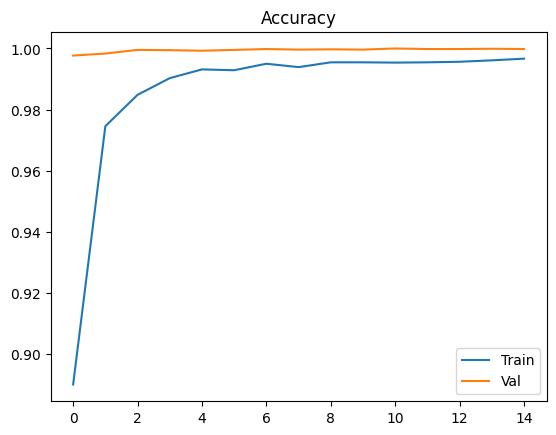

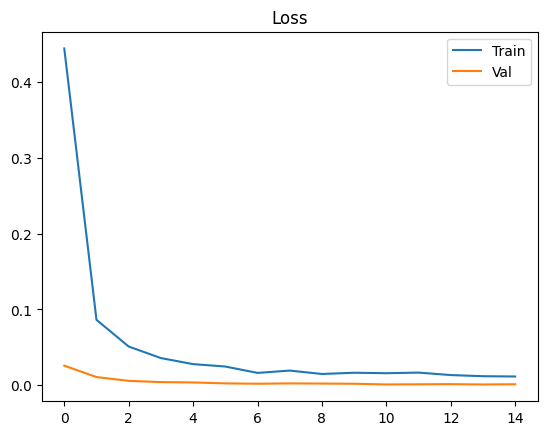

In [30]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Accuracy")
plt.legend(["Train", "Val"])
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Loss")
plt.legend(["Train", "Val"])
plt.show()


#Test Cell

In [44]:
import tensorflow as tf
from tensorflow.keras.layers import Layer
from tensorflow.keras.saving import register_keras_serializable

@register_keras_serializable()
class SpatialAttention(Layer):
    def __init__(self, **kwargs):
        super(SpatialAttention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.conv = tf.keras.layers.Conv2D(
            filters=1,
            kernel_size=7,
            padding='same',
            activation='sigmoid'
        )

    def call(self, inputs):
        attention = self.conv(inputs)
        return inputs * attention


In [43]:
@register_keras_serializable()
class SpatialAttention(Layer):
    def __init__(self, **kwargs):
        super(SpatialAttention, self).__init__(**kwargs)
        self.conv = None

    def build(self, input_shape):
        self.conv = tf.keras.layers.Conv2D(
            filters=1,
            kernel_size=7,
            padding='same',
            activation='sigmoid'
        )
        super(SpatialAttention, self).build(input_shape)

    def call(self, inputs):
        avg_pool = tf.reduce_mean(inputs, axis=-1, keepdims=True)
        max_pool = tf.reduce_max(inputs, axis=-1, keepdims=True)
        concat = tf.concat([avg_pool, max_pool], axis=-1)
        attention = self.conv(concat)
        return inputs * attention

    def get_config(self):
        config = super(SpatialAttention, self).get_config()
        return config

338/338 ━━━━━━━━━━━━━━━━━━━━ 657s 2s/step


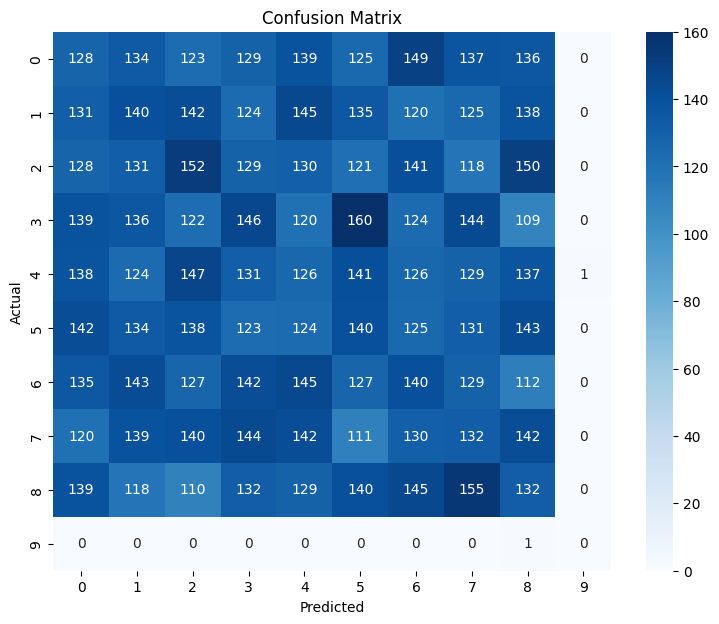

              precision    recall  f1-score   support

           0       0.11      0.11      0.11      1200
           1       0.12      0.12      0.12      1200
           2       0.13      0.13      0.13      1200
           3       0.12      0.12      0.12      1200
           4       0.10      0.10      0.10      1200
           5       0.12      0.12      0.12      1200
           6       0.12      0.12      0.12      1200
           7       0.11      0.11      0.11      1200
           8       0.11      0.11      0.11      1200
           9       0.00      0.00      0.00         1

    accuracy                           0.11     10801
   macro avg       0.10      0.10      0.10     10801
weighted avg       0.11      0.11      0.11     10801



In [46]:

from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Get true labels and predictions from validation generator
val_generator.reset()
preds = model.predict(val_generator)
y_pred = np.argmax(preds, axis=1)
y_true = val_generator.classes

# 2. Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(9, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# 3. Classification Report
print(classification_report(y_true, y_pred))
